<a href="https://colab.research.google.com/github/aitorvv/road_to_AI/blob/main/Tensorflow/Zero_to_Mastery/on_air_notebooks/04_transfer_learning_with_TF_part1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with Tensorflow Part 1: Feature Extraction

Two main benefits:
- Can leverage an existing neural network architecture proven to work on problems similar to our own
- Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [ ]:
# Change runtime to GPU
# Are we using a GPU?
!nvidia-smi

Mon Mar 13 17:24:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with data

In [ ]:
# Get data (10% of 10 food clases from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-03-13 17:24:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 172.253.114.128, 172.253.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   124MB/s    in 1.3s    

2023-03-13 17:24:09 (124 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 % data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

There are 2 directories and 0 images in "10_food_classes_10_percent".
There are 10 directories and 0 images in "10_food_classes_10_percent/test".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/ice_cream".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/ramen".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/pizza".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/chicken_curry".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/chicken_wings".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/fried_rice".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/hamburger".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/grilled_salmon".
There are 0 directories and 250 images in "10_food_classes_10_percent/test/sushi".
There are 0 directories and 250 images in "10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the 'ImageDataGenerator' class to load in our images in batches

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Capitals are HYPERPARAMETERS
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode='categorical')

print('Testing images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode='categorical')


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
- Tracking experiments with the TensorBoard callback
- Model checkpoint with the ModelCheckpoint callback
- Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log file to: {log_dir}')
  return tensorboard_callback

## Creating models using TensorFlow Hub

Models: 
- https://tfhub.dev/google/efficientnet/b0/feature-vector/1
- https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [ ]:
# Let's compare the following 2 models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned patterns

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model                                     


### Creating and testing Resnet model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url, 
                            num_classes=train_data_10_percent.num_classes)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# Compile our resnet model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet_v2_50')])

Saving TensorBoard log file to: tensorflow_hub/resnet_v2_50/20230313-172434
Epoch 1/5
24/24 [==============================] - 48s 1s/step - loss: 1.9504 - accuracy: 0.3613 - val_loss: 1.2025 - val_accuracy: 0.6372
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.8986 - accuracy: 0.7307 - val_loss: 0.8436 - val_accuracy: 0.7316
Epoch 3/5
24/24 [==============================] - 48s 2s/step - loss: 0.6350 - accuracy: 0.8267 - val_loss: 0.7487 - val_accuracy: 0.7608
Epoch 4/5
24/24 [==============================] - 21s 917ms/step - loss: 0.4771 - accuracy: 0.8893 - val_loss: 0.7169 - val_accuracy: 0.7556
Epoch 5/5
24/24 [==============================] - 19s 816ms/step - loss: 0.3896 - accuracy: 0.9093 - val_loss: 0.6806 - val_accuracy: 0.7712


In [ ]:
# Let's create a function to plot loss curves
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """ 
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

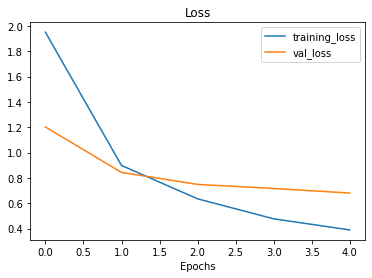

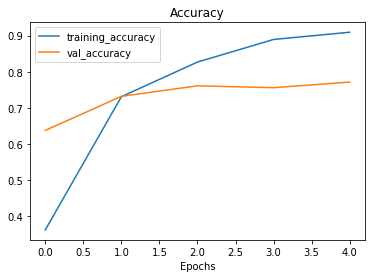

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNet model

In [ ]:
# Create EfficientNet model
effnet_model = create_model(model_url=efficientnet_url,
                      num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile the model
effnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit EfficientNet model to 10% of training data
effnet_history = effnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='effnet')])

Saving TensorBoard log file to: tensorflow_hub/effnet/20230313-172846
Epoch 1/5
24/24 [==============================] - 31s 1s/step - loss: 1.8533 - accuracy: 0.4333 - val_loss: 1.2886 - val_accuracy: 0.7432
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 1.0518 - accuracy: 0.7893 - val_loss: 0.8546 - val_accuracy: 0.8300
Epoch 3/5
24/24 [==============================] - 18s 784ms/step - loss: 0.7465 - accuracy: 0.8320 - val_loss: 0.6860 - val_accuracy: 0.8512
Epoch 4/5
24/24 [==============================] - 45s 2s/step - loss: 0.6011 - accuracy: 0.8560 - val_loss: 0.6007 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.5082 - accuracy: 0.8933 - val_loss: 0.5490 - val_accuracy: 0.8624


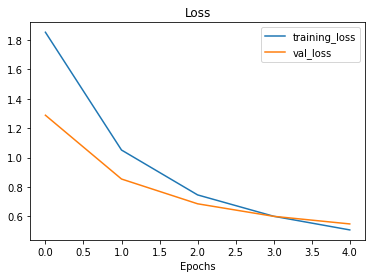

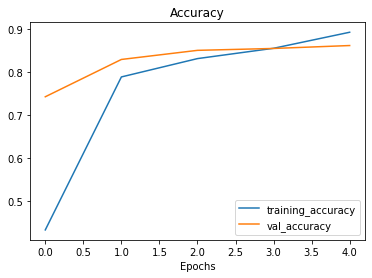

In [ ]:
plot_loss_curves(effnet_history)

In [ ]:
effnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learning

- **As is** transfer learning - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
- **Feature extraction** transfer learning - use the prelearned patterns of an existing model (e.g EfficientNetb0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
- **Fine-tuning** transfer learning - use the prelearned patterns of an existing model and 'fine-tune' many or all of the underlying layers (including new output layers)

## Comparing our model results using TensorBoard

When you upload things to TensorBoard.dev, your experiments are public

In [ ]:
# upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'effnet vs resnet' \
  --description 'Comparing two different TF Hub feature extraction model architectures using just 10% of training data' \
  --one_shot

Published here: https://tensorboard.dev/experiment/pMj76lnMSdGl0YEsMZLjsg/#scalars

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id 